In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipas.collection_no_db.iceagg_collection as collect
import matplotlib.pyplot as plt
import numpy as np
import time
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask
import pandas as pd
from dask import dataframe as dd
import pickle

In [5]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='10000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(1)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS_v1.3.0/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42397 instead
  http_address["port"], self.http_server.port


In [8]:
client = Client(cluster)
client

Client Scheduler: tcp://169.226.65.141:45891 Dashboard: http://169.226.65.141:42397/status,Cluster Workers: 1 Cores: 1 Memory: 9.77 GiB


In [13]:
client.retire_workers()

{'tcp://169.226.65.49:34509': {'type': 'Worker',
  'id': 0,
  'host': '169.226.65.49',
  'resources': {},
  'local_directory': '/network/rit/lab/sulialab/share/IPAS/ipas/executables/collection_no_db/dask-worker-space/worker-w_vghkv2',
  'name': 0,
  'nthreads': 1,
  'memory_limit': 10490457620,
  'last_seen': 1620485753.8571408,
  'services': {'dashboard': 35407},
  'metrics': {'executing': 0,
   'in_memory': 0,
   'ready': 0,
   'in_flight': 0,
   'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
   'spilled_nbytes': 0,
   'cpu': 0.0,
   'memory': 105508864,
   'time': 1620485753.8562794,
   'read_bytes': 4190.062036290083,
   'write_bytes': 7485.818311618776,
   'num_fds': 24},
  'nanny': 'tcp://169.226.65.49:33465'}}

In [5]:
def main():
    output = np.empty((len(phioarr),len(reqarr), nclusters),dtype=object)
    for phi in range(len(phioarr)):
        for r in range(len(reqarr)):
            for n in range(nclusters):
                #output[phi,r,n] = dask.delayed(collect.collect_clusters_iceagg)(phioarr[phi], reqarr[r], ncrystals, rand_orient)
                collect.collect_clusters_iceagg(phioarr[phi], reqarr[r], ncrystals, rand_orient)
    return output

In [6]:
def compute():
    agg_as = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    agg_bs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    agg_cs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    phi2Ds = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    cplxs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    dds = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    
    gather = client.compute([*output.tolist()])
    gather = client.gather(gather)

    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0]
    agg_bs = gather[:,:,1]
    print(agg_bs)
    agg_cs = gather[:,:,2]
    phi2Ds = gather[:,:,3]
    cplxs = gather[:,:,4] 
    dds = gather[:,:,5]
    print('DONE!')
    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds


{'ncrystals': 1, 'rotation': Quaternion(1.0, 0.0, 0.0, 0.0), 'points': array([[( 23.24606312, -11.55577996,   0.85436887),
        ( 25.35194837,  -5.63395224,   0.4274848 ),
        ( 25.32102698,  -2.67303837,  -5.13282628),
        ( 23.18422034,  -5.63395224, -10.26625328),
        ( 21.07833509, -11.55577996,  -9.83936921),
        ( 21.10925648, -14.51669382,  -4.27905813),
        (-23.18422034,   5.63395224,  10.26625328),
        (-21.07833509,  11.55577996,   9.83936921),
        (-21.10925648,  14.51669382,   4.27905813),
        (-23.24606312,  11.55577996,  -0.85436887),
        (-25.35194837,   5.63395224,  -0.4274848 ),
        (-25.32102698,   2.67303837,   5.13282628)]],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8')]), 'add_points': None, 'orient_points': None, 'mono_phi': 4.0, 'mono_r': 10, 'tol_ellipse': 0.001}


AttributeError: 'Cluster' object has no attribute '_plot_crystal'

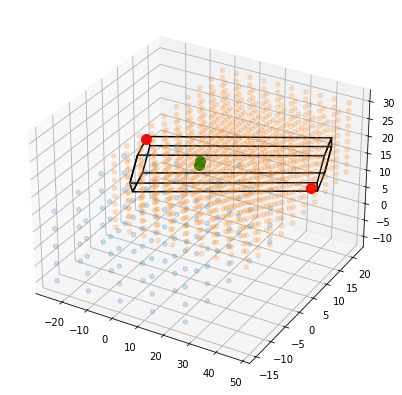

In [8]:
if __name__ == '__main__':
    # monomer aspect ratios (all the same in agg)
    #phioarr=np.logspace(-2, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    phioarr = [4, 0.25, 0.5, 1.0, 2.0, 4.0, 10.]
    # monomer radii 
    #reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    reqarr = [10]
    # how many aggregates to produce
    nclusters = 300
    # number of monomers per aggregate
    ncrystals = 2
    # monomer orientation - random (True) or flat (False)
    rand_orient = False

    output = main()
    agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds = compute()


In [31]:
#write results to file
with open('../instance_files/instance_iceagg_flat_r10_compareDunnavan_1', "ab") as f:
    pickle.dump((agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths), f)
    f.close()

NameError: name 'agg_as' is not defined